In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 对于任务一的考核内容，可以直接跳至本文档最后一个代码块

# 读取数据集

In [6]:
#开始准备数据集
import pathlib
data_dir="capacity_data"
data_dir = pathlib.Path(data_dir)
print(data_dir)

capacity_data


In [3]:
# 数据集规模
image_count = len(list(data_dir.glob('*/*.bmp')))
print(image_count)
# print(data_dir.stat())

3840


# 数据预处理

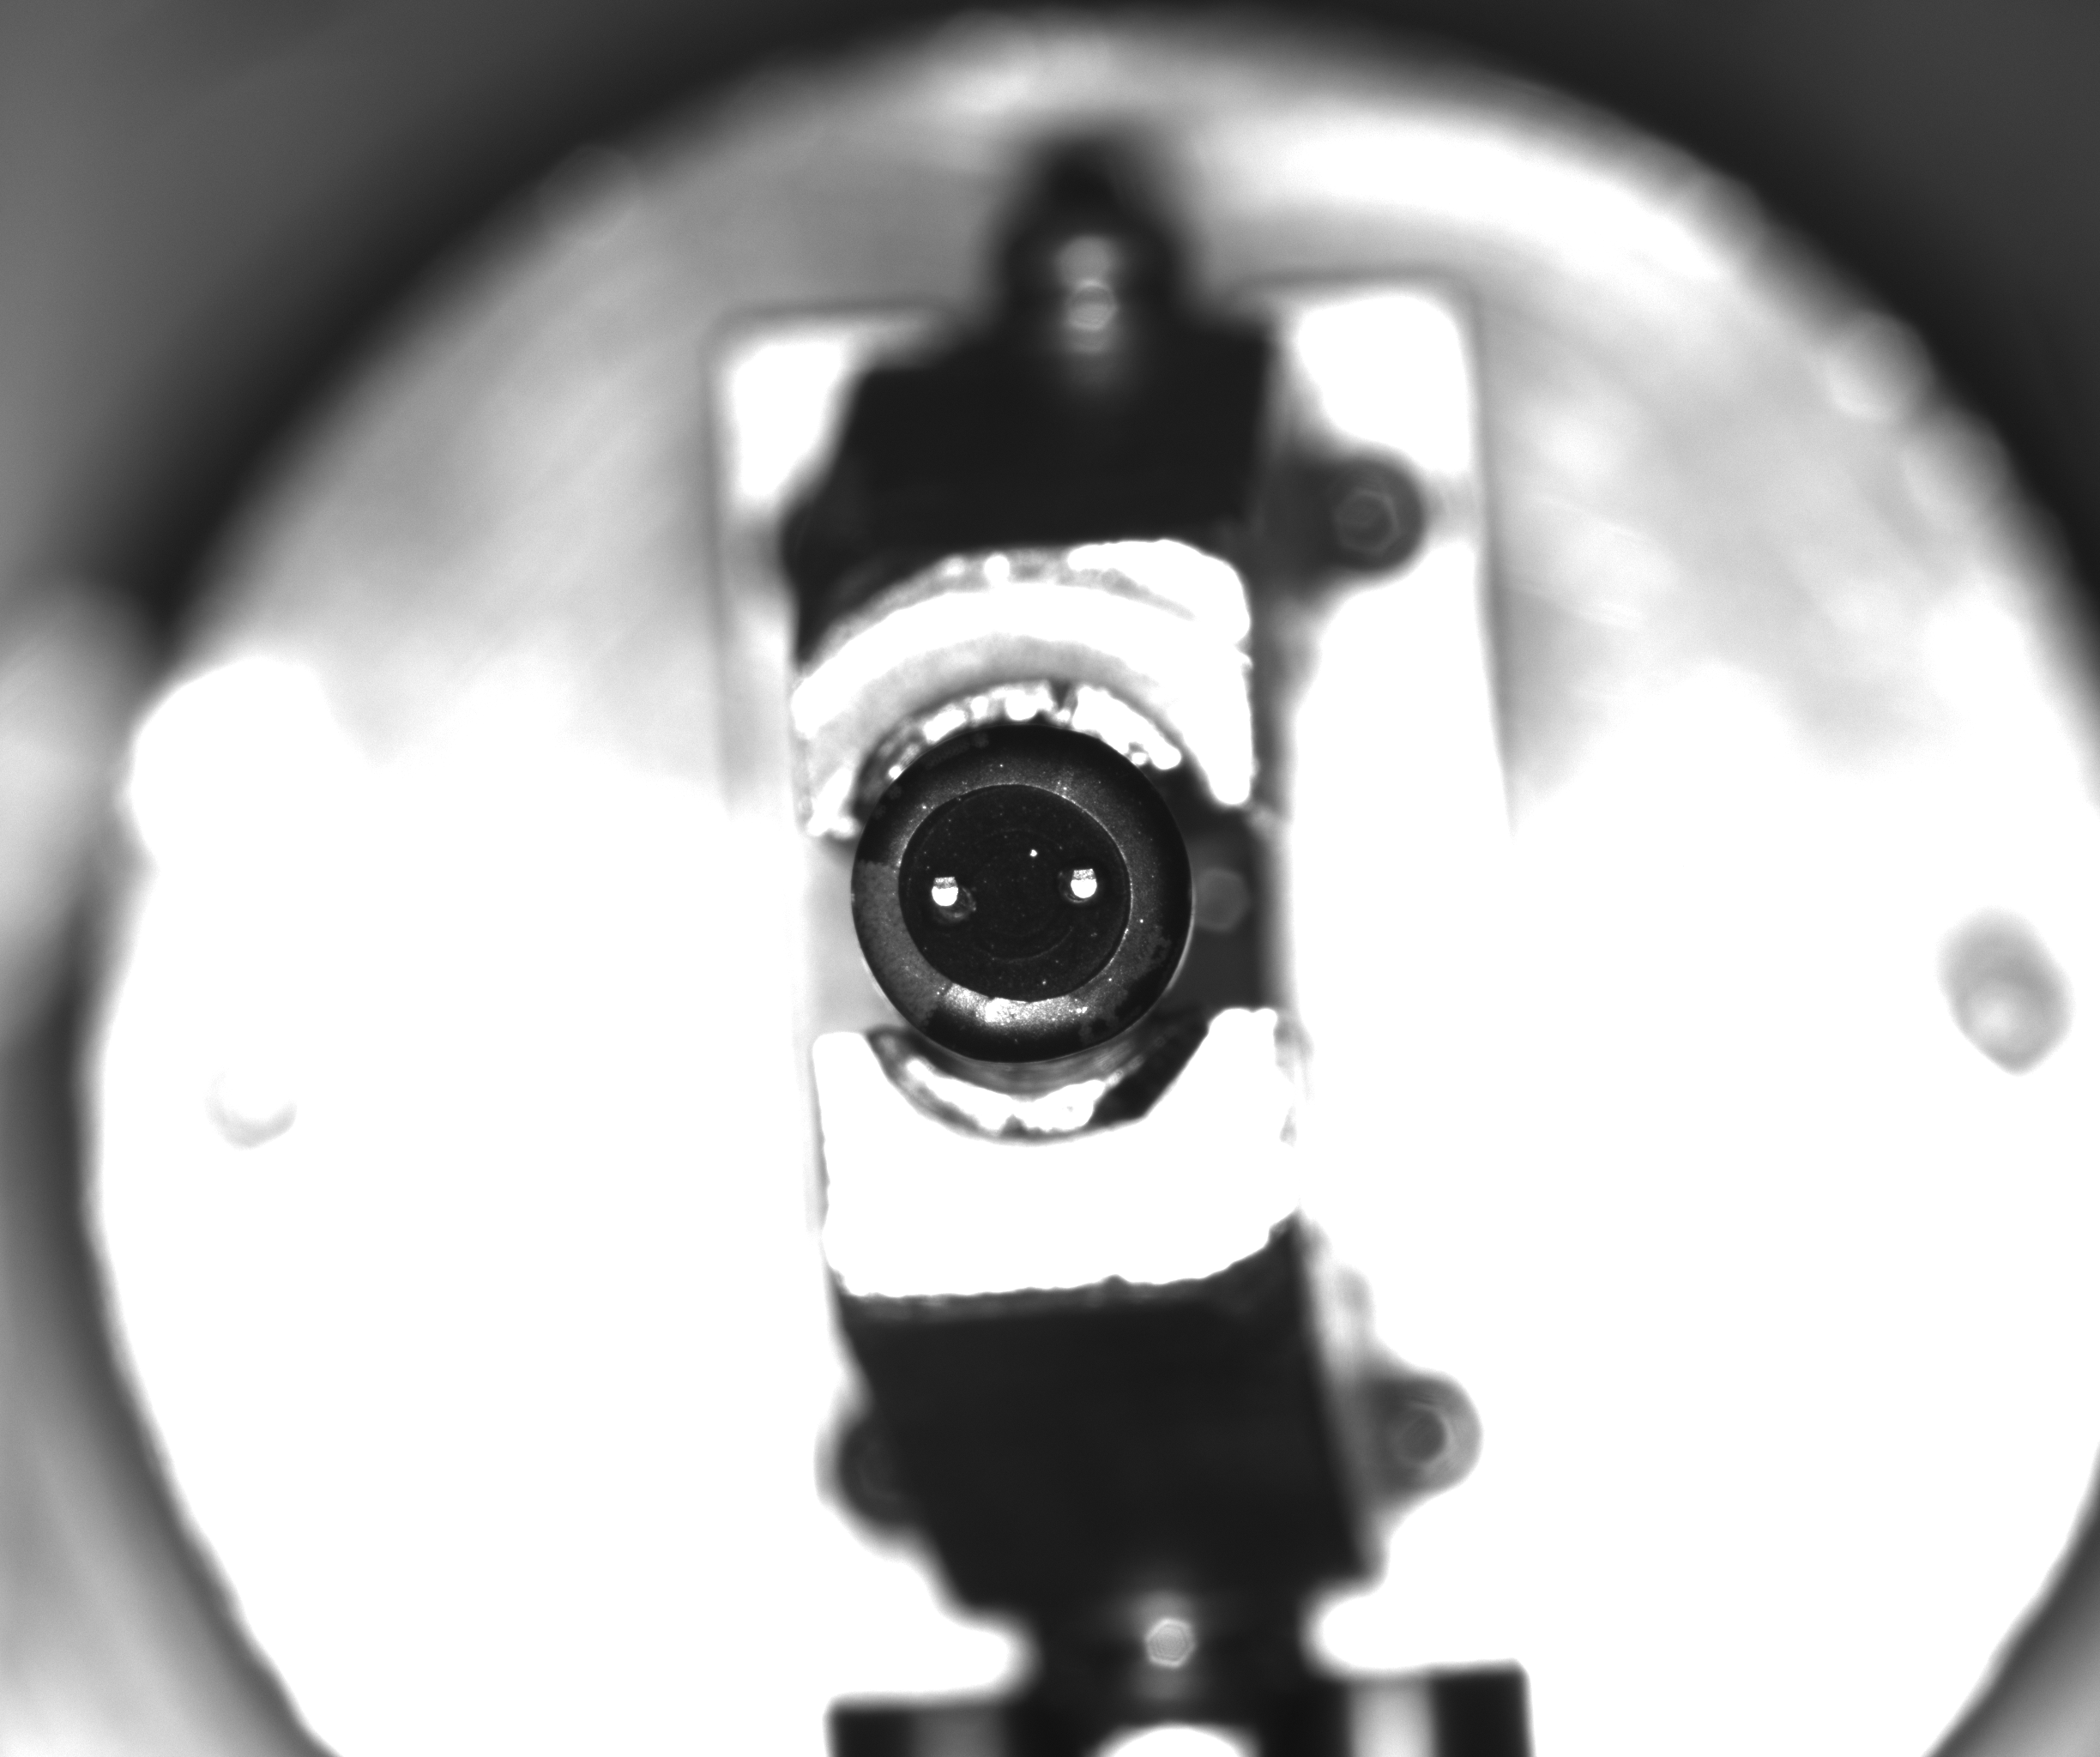

In [4]:
qualified = list(data_dir.glob('qualified/*'))

# 若后续报错提示有损坏图像，可去除下列代码注释进行检测
# for absolute_path in qualified:
#     try:
#         img = PIL.Image.open(absolute_path)
#     except IOError:
#         print(absolute_path)
#     try:
#         img = np.asarray(img)
#     except:
#         print('corrupt img', absolute_path)

PIL.Image.open(str(qualified[0]))

In [5]:
# PIL.Image.open(str(qualified[1]))

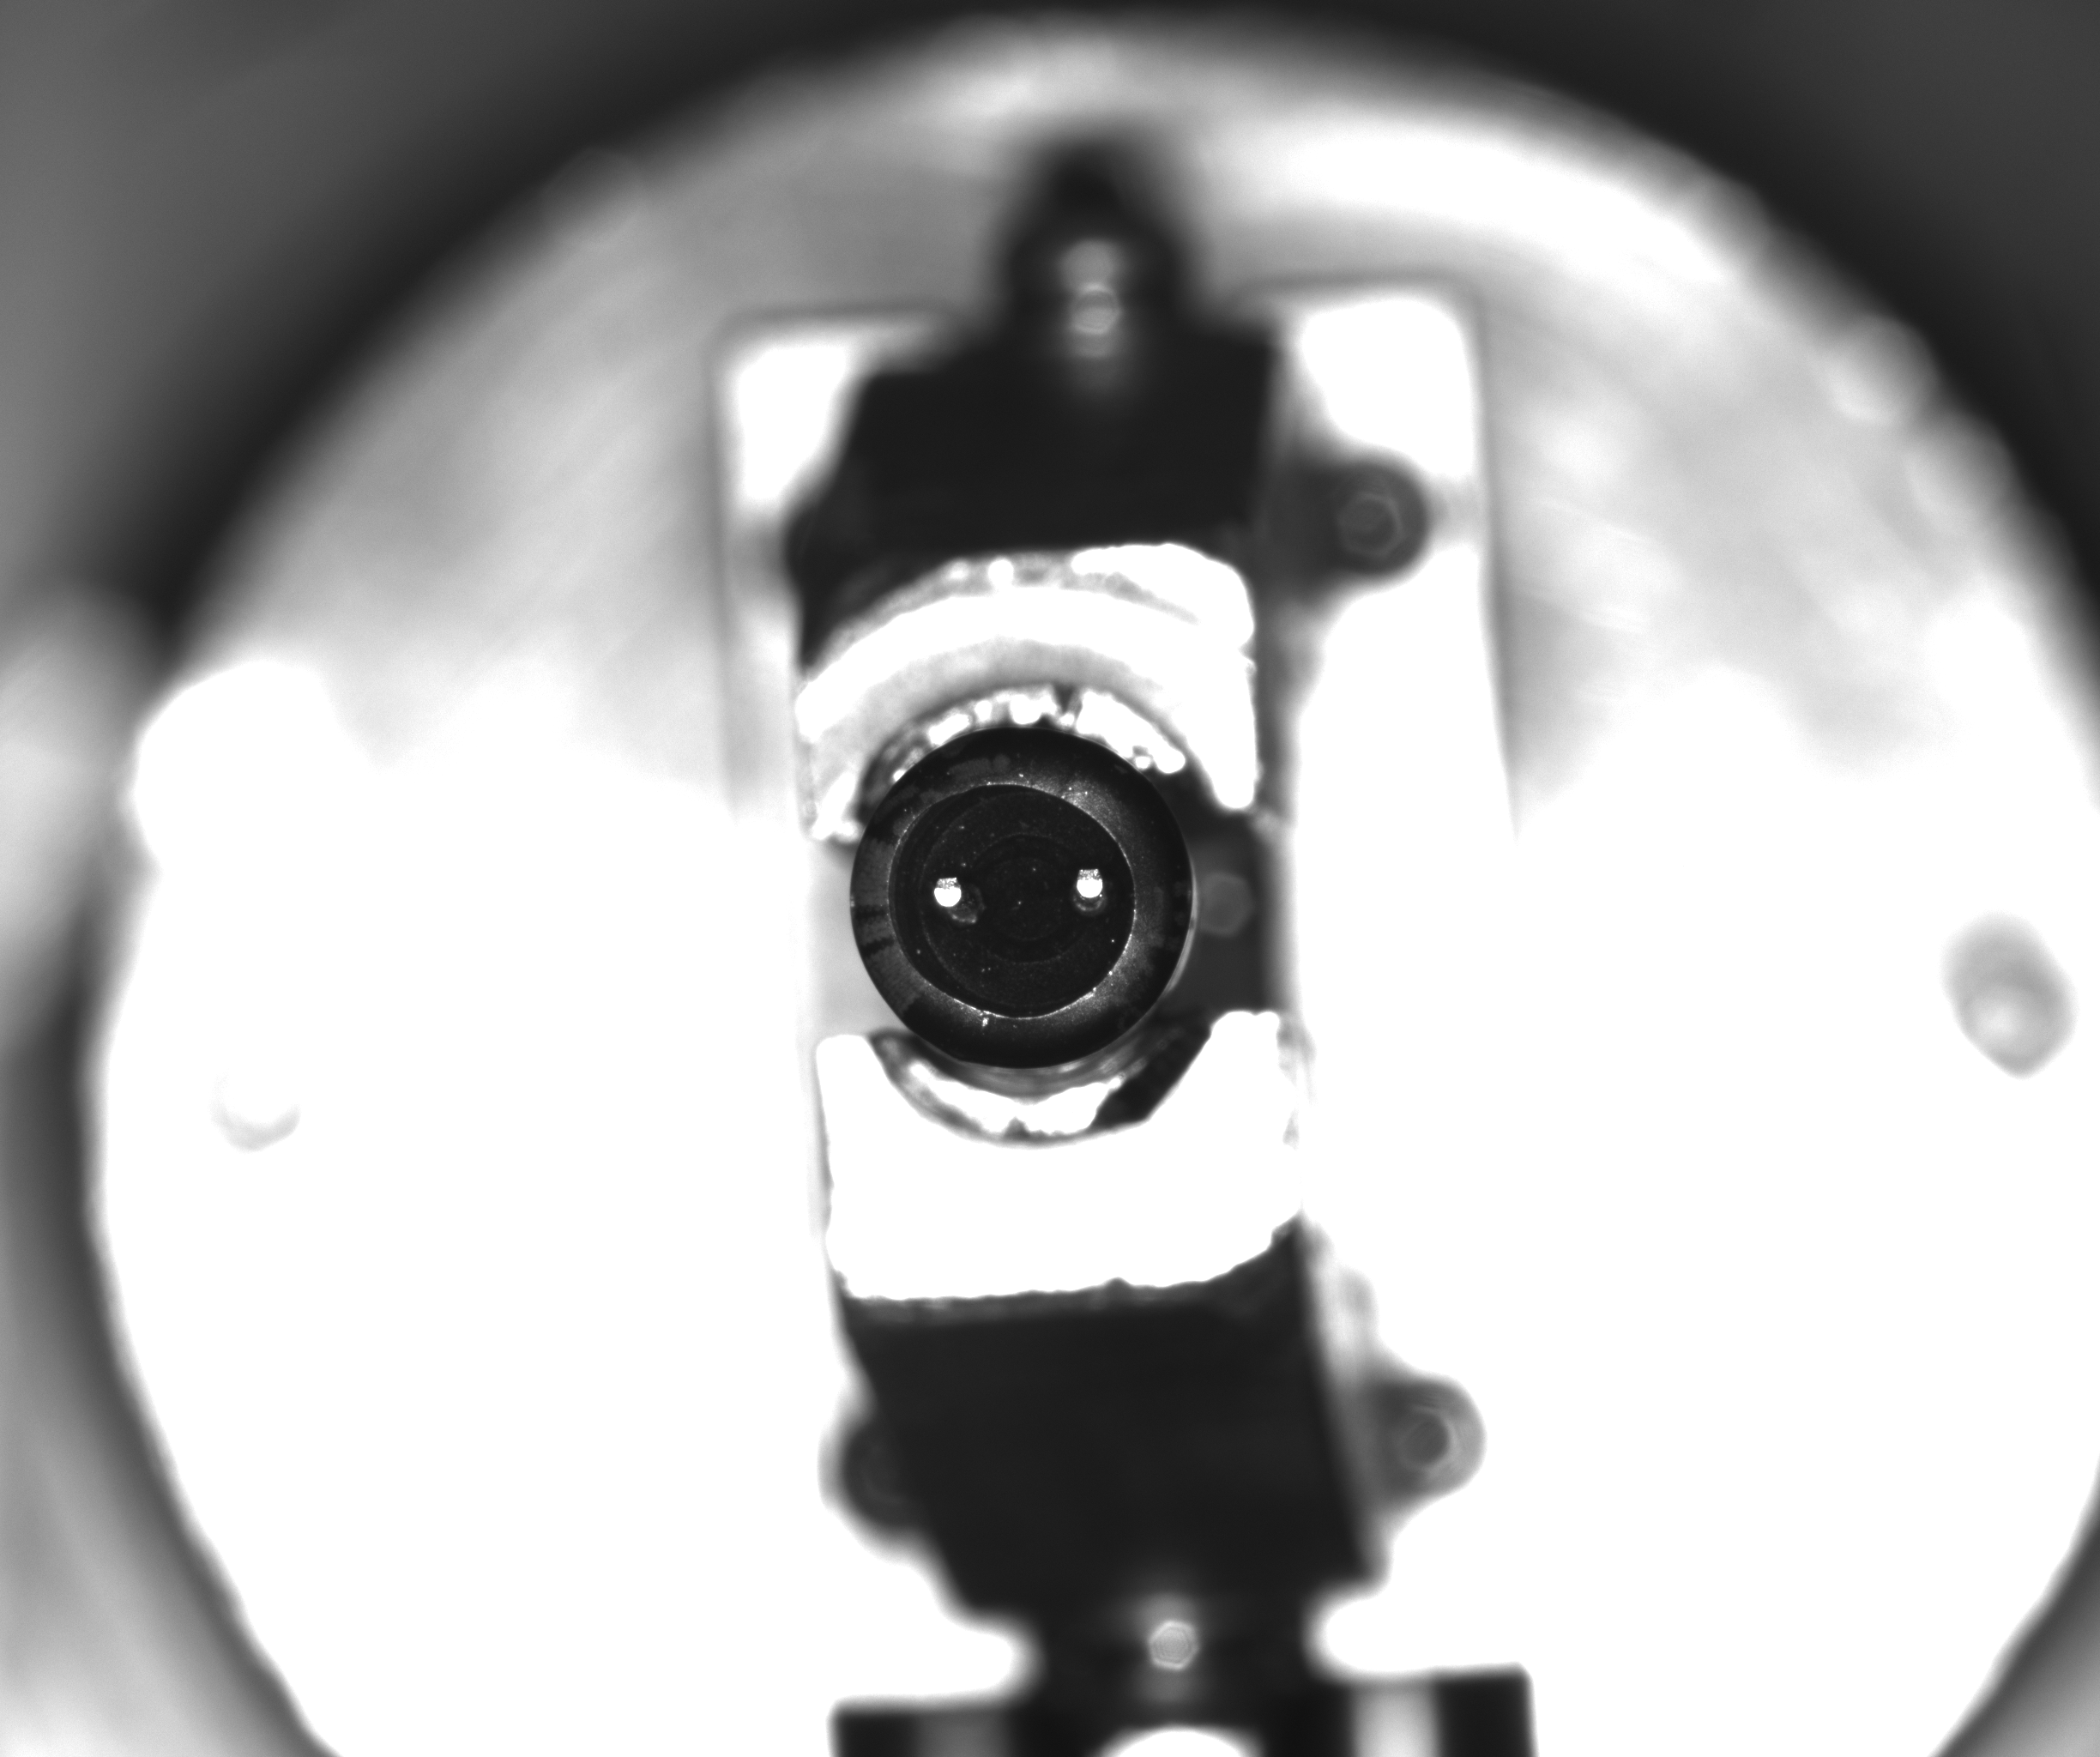

In [6]:
unqualified = list(data_dir.glob('unqualified/*'))

# 若后续报错提示有损坏图像，可去除下列代码注释进行检测
# for absolute_path in unqualified:
#     try:
#         img = PIL.Image.open(absolute_path)
#     except IOError:
#         print(absolute_path)
#     try:
#         img = np.asarray(img)
#     except:
#         print('corrupt img', absolute_path)

PIL.Image.open(str(unqualified[0]))

In [7]:
# PIL.Image.open(str(unqualified[1]))

In [8]:
# 模型参数设置
batch_size = 64
img_height = 180
img_width = 180

In [11]:
#训练集设置
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3840 files belonging to 2 classes.
Using 2304 files for training.


In [10]:
#验证集设置
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3840 files belonging to 2 classes.
Using 1536 files for validation.


In [11]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 12


In [12]:
#类别统计
class_names = train_ds.class_names
print(class_names)

['qualified', 'unqualified']


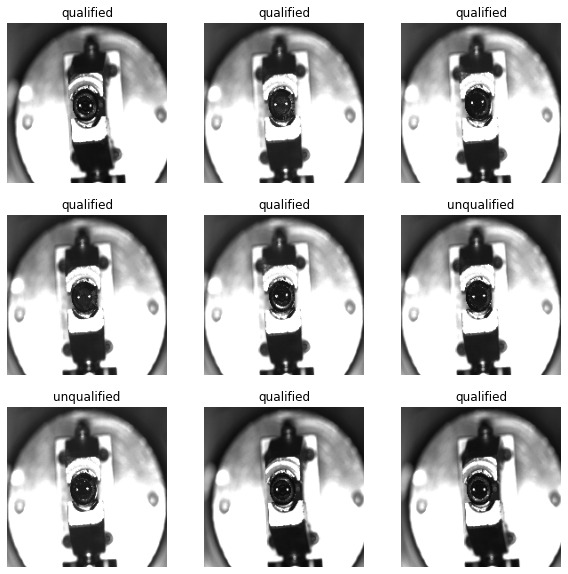

In [13]:
#绘制出前九张数据集图像
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
#灰度图像数据归一化
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.035403267 1.0


In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

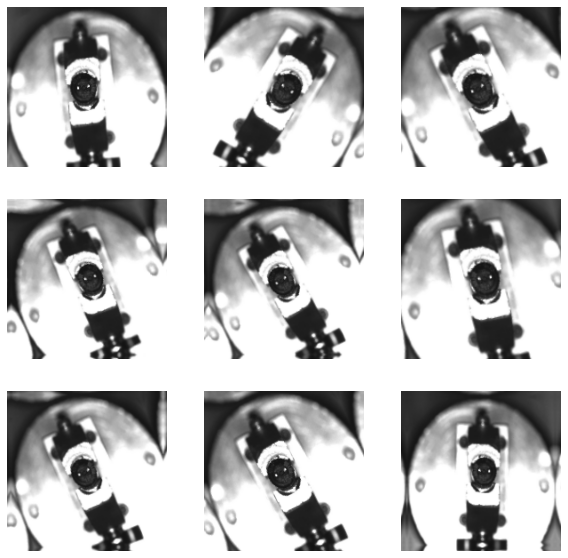

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 模型搭建，训练以及保存

In [20]:
# #模型搭建
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
#设置为分类型机器学习问题
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [23]:
# 模型训练与保存
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model.save(r'model\\model_8.h5')
print("模型保存成功！")


Epoch 1/15
36/36 [==============================] - 64s 2s/step - loss: 0.4757 - accuracy: 0.8676 - val_loss: 0.3810 - val_accuracy: 0.8737
Epoch 2/15
36/36 [==============================] - 29s 808ms/step - loss: 0.3158 - accuracy: 0.8763 - val_loss: 0.2388 - val_accuracy: 0.8880
Epoch 3/15
36/36 [==============================] - 29s 812ms/step - loss: 0.2102 - accuracy: 0.9345 - val_loss: 0.1796 - val_accuracy: 0.9440
Epoch 4/15
36/36 [==============================] - 29s 818ms/step - loss: 0.1868 - accuracy: 0.9392 - val_loss: 0.1727 - val_accuracy: 0.9453
Epoch 5/15
36/36 [==============================] - 29s 815ms/step - loss: 0.1736 - accuracy: 0.9453 - val_loss: 0.1803 - val_accuracy: 0.9375
Epoch 6/15
36/36 [==============================] - 29s 816ms/step - loss: 0.1701 - accuracy: 0.9423 - val_loss: 0.1652 - val_accuracy: 0.9440
Epoch 7/15
36/36 [==============================] - 29s 802ms/step - loss: 0.1662 - accuracy: 0.9444 - val_loss: 0.1744 - val_accuracy: 0.9375
Ep

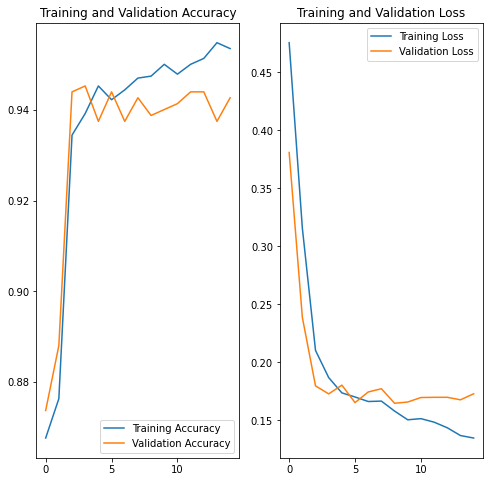

In [24]:
#绘制准确率及损失函数曲线
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 模型评估

In [25]:
# 读取现有模型
model=tf.keras.models.load_model(r'model\\model_8.h5')

In [26]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

12/12 [==============================] - 30s 2s/step - loss: 0.1319 - accuracy: 0.9505
Test accuracy : 0.9505208134651184


In [27]:
#测试集错判概率
test_label=[]
error_un=0
num_un=0
error_qu=0
num_qu=0
for element in test_ds.as_numpy_iterator():
    image_batch, label_batch=element
    num_un=num_un+list(label_batch).count(1)
    num_qu=num_qu+list(label_batch).count(0)
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(predictions)
    score=[]
    for i in range(len(predictions)):
        score.append(np.argmax(predictions[i]))
    score=np.array(score).flatten()
    for i in range(len(score)):
        if(score[i]!=label_batch[i]):
            if(label_batch[i]==0):
                error_qu=error_qu+1
            else:
                error_un=error_un+1
print("unqualified的错判概率为："+str(error_un/num_un))
print("qualified的错判概率为："+str(error_qu/num_qu))

unqualified的错判概率为：0.19540229885057472
qualified的错判概率为：0.02643171806167401


In [28]:
#单幅图像结果预测
test_path = "capacity_data\\unqualified\\10 (4).bmp"

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# print(predictions)
score = tf.nn.softmax(predictions[0])
# print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to unqualified with a 97.32 percent confidence.


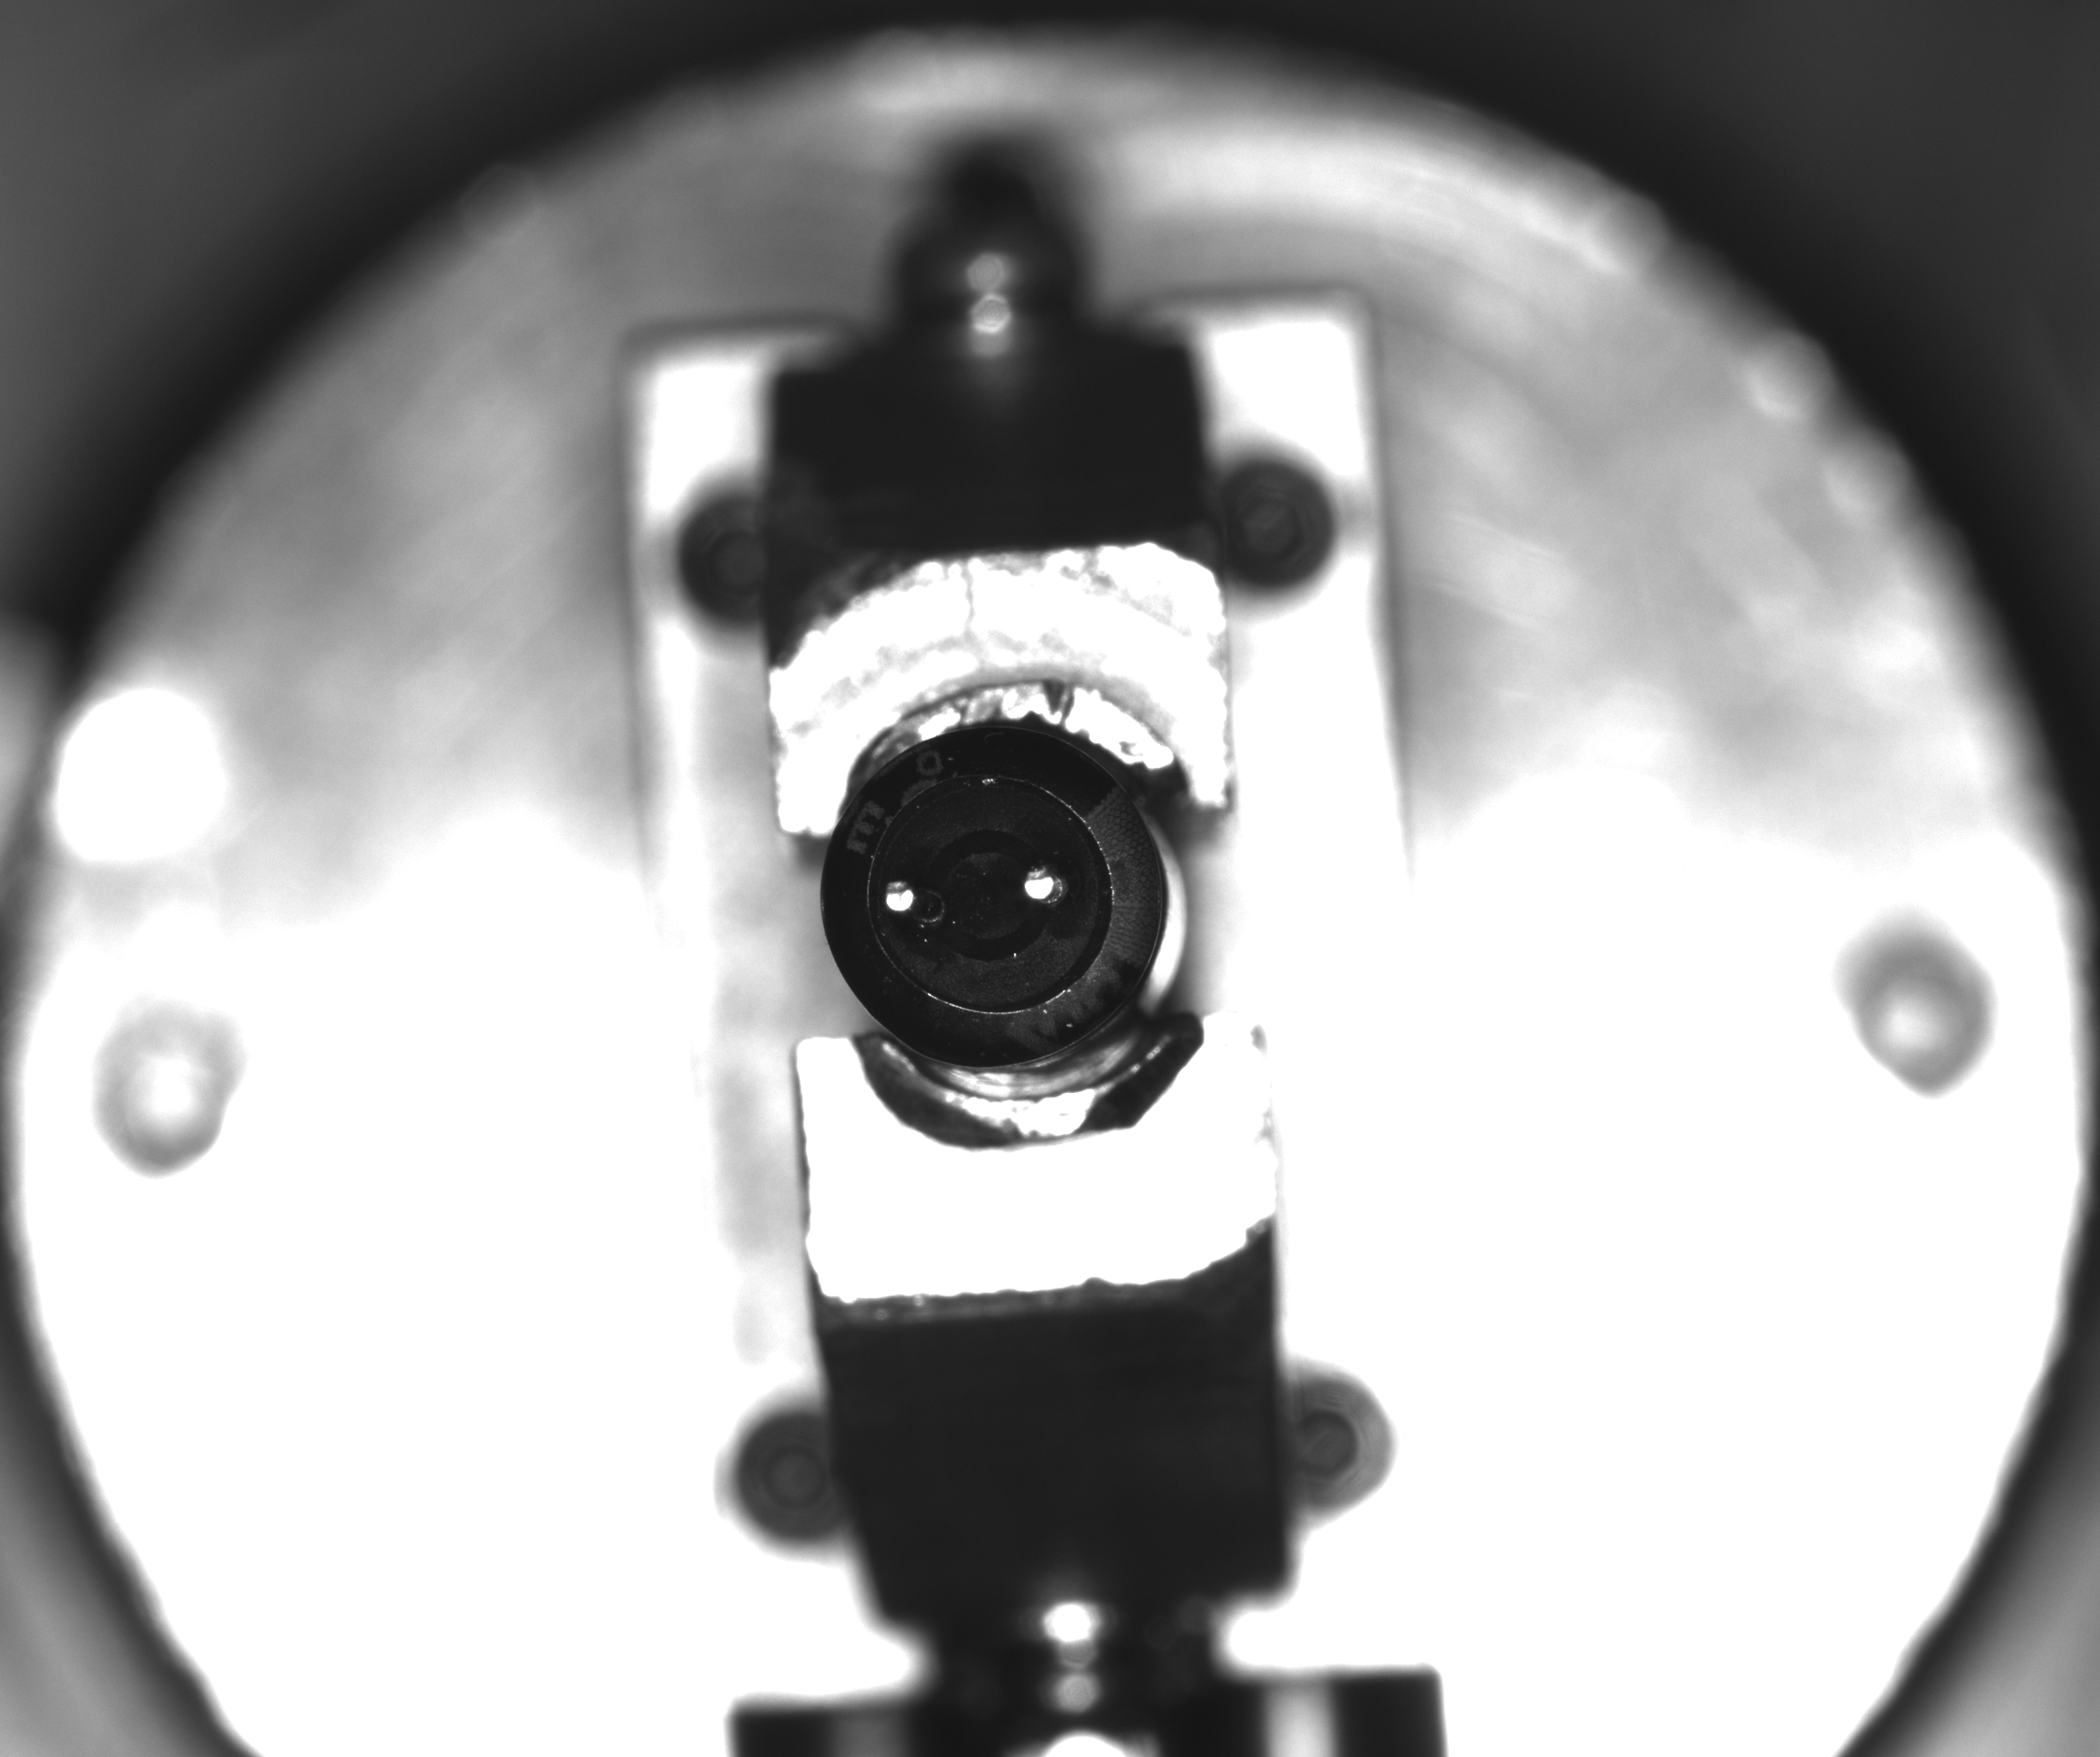

In [29]:
PIL.Image.open(test_path)

# 考核内容，可以直接跳至此处，修改文件路径即可运行

In [20]:
# 读取现有模型
model=tf.keras.models.load_model(r'model\\model_8.h5')
#对于某文件夹内的图像预测
test_path1 = ""
test_path1 = pathlib.Path(test_path1)
test1= list(test_path1.glob('test1/*'))
img_class=[]
for i in range(len(test1)):
    img1=tf.keras.utils.load_img(str(test1[i]), target_size=(img_height, img_width))
    img_array1=tf.keras.utils.img_to_array(img1)
    img_array1 = tf.expand_dims(img_array1, 0)
    predictions1 = model.predict(img_array1)
    score1 = tf.nn.softmax(predictions1[0])
    img_class1=class_names[np.argmax(score1)]
    img_class.append(img_class1)

#输出预测结果到控制台，并将结果写入result1.txt
print("该文件夹中，判定有"+str(img_class.count("qualified"))+"张合格电容图片，"+str(img_class.count("unqualified"))+"张不合格电容图片")    
file = open('result1\\result1.txt','w')
file.write('该文件夹中，判定有'+str(img_class.count('qualified'))+'张合格电容图片，'+str(img_class.count('unqualified'))+'张不合格电容图片')
file.write('\n')

for i in range(len(test1)):
    print("Path:"+str(test1[i])+"   "+str(img_class[i]))
    file.write(str(test1[i])[6:]+"   "+str(img_class[i]))
    file.write('\n')

Path:test2\1 (4).bmp   unqualified
Path:test2\1 (5).bmp   qualified
Path:test2\10 (104).bmp   unqualified
Path:test2\10 (105).bmp   unqualified
Path:test2\10 (114).bmp   unqualified
Path:test2\10 (115).bmp   unqualified
Path:test2\10 (124).bmp   unqualified
Path:test2\10 (125).bmp   unqualified
Path:test2\10 (134).bmp   unqualified
Path:test2\10 (135).bmp   unqualified
Path:test2\10 (14).bmp   unqualified
Path:test2\10 (144).bmp   unqualified
Path:test2\10 (145).bmp   unqualified
Path:test2\10 (15).bmp   unqualified
Path:test2\10 (154).bmp   unqualified
Path:test2\10 (155).bmp   unqualified
Path:test2\10 (164).bmp   unqualified
Path:test2\10 (165).bmp   qualified
Path:test2\10 (174).bmp   unqualified
Path:test2\10 (175).bmp   unqualified
Path:test2\10 (184).bmp   qualified
Path:test2\10 (185).bmp   unqualified
Path:test2\10 (194).bmp   unqualified
Path:test2\10 (195).bmp   qualified
Path:test2\10 (204).bmp   unqualified
Path:test2\10 (205).bmp   unqualified
Path:test2\10 (214).bmp   un